<a href="https://colab.research.google.com/github/ajainf/AI_Energy/blob/main/Part_2_Get_Thermal_Image_Data_and_Stats_for_Footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clipping Thermal Satellite Imagery with SF Building Footprints

This notebook is used to obtain VIIRS thermal imagery and connect it to SF Building Footprint Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Building Footprints geometry
import geopandas as gpd
path = '/content/drive/MyDrive/ai_energy_capstone_schools'
bldgs_energy = gpd.read_file(path +r'/data_sf_open_data/SF_BuildingFootprints_Energy_Simpler.shp')

# Boundary
sf_boundary = gpd.read_file(path+r'/data_sf_boundary/SF_county_only.shp')

In [ ]:
print(bldgs_energy.columns)
print(bldgs_energy.shape)

Index(['hgt_cells5', 'hgt_mincm', 'hgt_maxcm', 'hgt_rangec', 'hgt_meancm',
       'hgt_stdcm', 'hgt_variet', 'hgt_majori', 'hgt_minori', 'hgt_median',
       'gnd_min_m', 'median_1st', 'hgt_medi_1', 'unique_ide', 'Parcel Num',
       'Building N', 'Building A', 'Postal Cod', 'Floor Area', 'Category',
       'Property T', 'PIM Link', 'Year Built', 'Benchmark', 'ENERGY STA',
       'Site EUI (', 'Source EUI', 'Percent Be', 'Weather No', 'Weather _1',
       'Total GHG', 'Total GH_1', 'Electricit', 'Natural Ga', 'District S',
       'Site Energ', 'Benchmar_1', 'Reason for', 'point', 'longitude',
       'latitude', 'analysis_n', 'supervisor', 'geometry'],
      dtype='object')
(22284, 44)


In [ ]:
# Filter out nans and select only 2018 to make the satellite imagery manageable
filter1 = bldgs_energy[~bldgs_energy['ENERGY STA'].isna()]
filter2 = filter1[filter1['Benchmark']==2018]

print(filter1.shape)
print(filter2.shape)

(8211, 44)
(854, 44)


In [ ]:
bldgs_data = filter2

Text(0.5, 1.0, 'Building Footprints for Buildings with Energy Score')

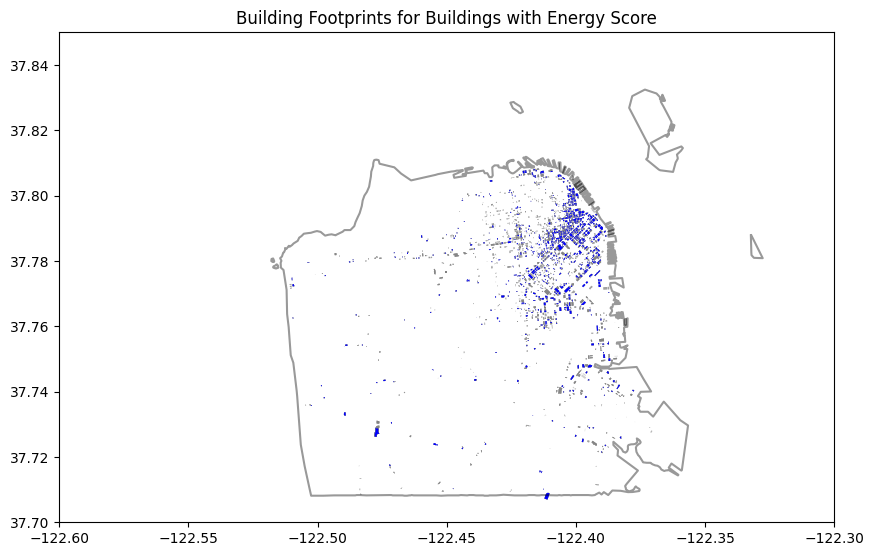

In [ ]:
import matplotlib.pyplot as plt

# create an Axes object and plot the map
fig, ax = plt.subplots(figsize=(10, 10))
sf_boundary.boundary.plot(ax=ax, color='black', alpha=0.4)
bldgs_energy.plot(ax=ax, color='grey', alpha=0.2)
bldgs_data.plot(ax=ax, color='blue')

ax.set_xlim(-122.6, -122.3)
ax.set_ylim(37.70, 37.85)
plt.title('Building Footprints for Buildings with Energy Score')

## Use Google Earth Engine to get VIIRS Thermal Image Info

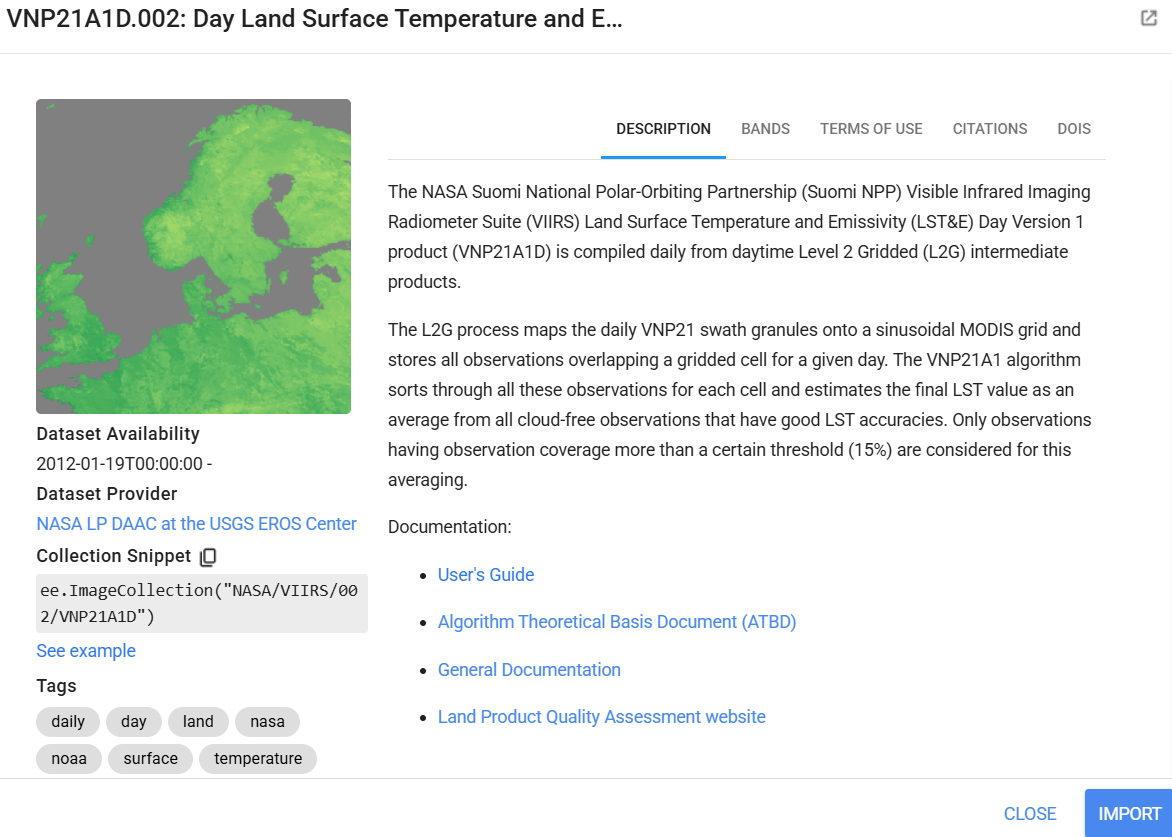

In [ ]:
import ee
import geemap.core as geemap
import json

ee.Authenticate()


True

In [ ]:
import ee
import pandas as pd
import geopandas as gpd
import json

# Initialize Earth Engine
ee.Initialize(project='lst-and-energy-use')

# Define feature collection - Daily Images
lst_collection = ee.ImageCollection('NASA/VIIRS/002/VNP21A1D').filterDate('2018-01-01', '2019-01-01').select('LST_1KM').mean()

bldg_geometries = ee.FeatureCollection(json.loads(bldgs_data.to_json()))


In [ ]:


# Function to calculate mean Land Surface Temperature (LST) for each geometry
def calculate_mean_band(feature):

    band = 'LST_1KM'
    # Get the geometry of the current building
    geometry = feature.geometry()

    # Calculate the mean LST for the current  geometry
    mean_band = lst_collection.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=30 # Adjust scale as needed
    ).get(band) # Get the mean LST value could do with another band too

    # Return the school feature with the mean LST added as a property
    return feature.set('mean_lst', mean_band)



# Map the function over the  geometries
bldg_data_final = bldg_geometries.map(calculate_mean_band)


In [ ]:
# Export the results to a Pandas DataFrame - takes a while
bldg_df = pd.DataFrame(bldg_data_final.getInfo()['features'])

In [ ]:
print(bldg_df.columns)
print(bldg_df.shape)

Index(['type', 'geometry', 'id', 'properties'], dtype='object')
(854, 4)


In [ ]:

# Extract the mean LST values to a separate column
cols =['unique_ide','mean_lst','latitude','longitude']
for item in cols:
  bldg_df[item] = bldg_df['properties'].apply(lambda x: x.get(item,None))

In [ ]:
print(bldg_df.columns)
print(bldg_df.shape)

Index(['type', 'geometry', 'id', 'properties', 'unique_ide', 'mean_lst',
       'latitude', 'longitude'],
      dtype='object')
(854, 8)


In [ ]:
# Display the DataFrame
thermal_df = bldg_df[['unique_ide', 'mean_lst','latitude', 'longitude']]
print(thermal_df)

         unique_ide    mean_lst   latitude   longitude
0     7296/006_2018  299.734242  37.726530 -122.477538
1    6309/004A_2018  301.881531  37.708785 -122.411118
2     3705/052_2018  301.346710  37.784100 -122.406145
3     3783/009_2018  303.886388  37.771022 -122.403546
4     3781/003_2018  303.921241  37.771028 -122.407314
..              ...         ...        ...         ...
849   0270/042_2018  298.763395  37.790869 -122.405226
850   3736/098_2018  298.763395  37.786906 -122.397672
851   0309/022_2018  301.327004  37.788400 -122.406517
852   0260/009_2018  300.886914  37.792177 -122.402028
853   3776/011_2018  300.337518  37.779931 -122.394868

[854 rows x 4 columns]


In [ ]:
# Export
#thermal_df.to_csv(path+r'/data_thermal/thermal_df.csv')

# Calculate Mean Min Max SD for the satellite image LST data

In [ ]:
def calculate_mean_band(feature):

    band = 'LST_1KM'
    # Get the geometry of the current building
    geometry = feature.geometry()

    # Calculate the mean LST for the current  geometry
    mean_band = lst_collection.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=30 # Adjust scale as needed
    ).get(band) # Get the mean LST value could do with another band too

        # Calculate the mean LST for the current  geometry
    max_band = lst_collection.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=geometry,
        scale=30 # Adjust scale as needed
    ).get(band) # Get the mean LST value could do with another band too

        # Calculate the mean LST for the current  geometry
    min_band = lst_collection.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=geometry,
        scale=30 # Adjust scale as needed
    ).get(band) # Get the mean LST value could do with another band too

        # Calculate the mean LST for the current  geometry
    sd_band = lst_collection.reduceRegion(
        reducer=ee.Reducer.stdDev(),
        geometry=geometry,
        scale=30 # Adjust scale as needed
    ).get(band) # Get the mean LST value could do with another band too

    # Return the school feature with the mean LST added as a property
    return feature.set('mean_lst', mean_band, 'max_lst', max_band,
                       'min_lst', min_band, 'sd_lst', sd_band)



# Map the function over the  geometries
bldg_data_final2 = bldg_geometries.map(calculate_mean_band)

# Export the results to a Pandas DataFrame - takes a while
bldg_df2 = pd.DataFrame(bldg_data_final2.getInfo()['features'])


# Extract the mean LST values to a separate column
cols =['unique_ide','mean_lst', 'max_lst','min_lst','sd_lst','latitude','longitude']
for item in cols:
  bldg_df2[item] = bldg_df2['properties'].apply(lambda x: x.get(item,None))


thermal_df2 = bldg_df2[['unique_ide','mean_lst', 'max_lst','min_lst','sd_lst','latitude','longitude']]
print(thermal_df2)


         unique_ide    mean_lst     max_lst     min_lst    sd_lst   latitude  \
0     7296/006_2018  299.734242  299.734242  299.734242  0.000012  37.726530   
1    6309/004A_2018  301.881531  302.959768  300.159360  1.347124  37.708785   
2     3705/052_2018  301.346710  301.327004  301.327004  0.000007  37.784100   
3     3783/009_2018  303.886388  303.886388  303.886388  0.000000  37.771022   
4     3781/003_2018  303.921241  303.926868  303.886388  0.015086  37.771028   
..              ...         ...         ...         ...       ...        ...   
849   0270/042_2018  298.763395         NaN         NaN       NaN  37.790869   
850   3736/098_2018  298.763395         NaN         NaN       NaN  37.786906   
851   0309/022_2018  301.327004  301.327004  301.327004  0.000000  37.788400   
852   0260/009_2018  300.886914         NaN         NaN       NaN  37.792177   
853   3776/011_2018  300.337518         NaN         NaN       NaN  37.779931   

      longitude  
0   -122.477538  
1  

In [ ]:
# Export
thermal_df2.to_csv(path+r'/data_thermal/thermal_df2.csv')

# For Visualizing

In [ ]:


# Initialize the Earth Engine API
ee.Initialize(project='lst-and-energy-use')


# SF Counties geometry
gdf = gpd.read_file(path+r'/data_sf_boundary/SF_county_only.shp')
geo_json = gdf.to_json()
featureCollection = ee.FeatureCollection(json.loads(geo_json))

#  Footprints geometry
bldg_geometries = ee.FeatureCollection(json.loads(bldgs_data.to_json()))

# Load thermal imagery from VIIRS
collection = (
    ee.ImageCollection('NASA/VIIRS/002/VNP21A1D')
    .filterDate('2018-01-01', '2019-01-01')
    .filterBounds(featureCollection.geometry()))

palette1= ['a50026','d73027','f46d43','fdae61','fee08b',
           'ffffbf','d9ef8b','a6d96a','66bd63', '1a9850','006837']


# Compute a mean image and display.
#median = collection.median()
mean = collection.mean()

# Clip to the Bay Area
clipped = mean.clip(featureCollection)

# Clip to the Building Footprints
bldg_clips = mean.clip(bldg_geometries)



In [ ]:
# Create Map

m = geemap.Map()

m.set_center(-122.3578, 37.7726, 12) # centered around San Fransisco
m.add_layer(bldg_geometries,{},'Building Footprints')
m.add_layer(featureCollection,{},'SF boundary')
m.add_layer(bldg_clips, {'bands': ['LST_1KM'], 'min':[150], 'max':[300], 'palette': palette1}, 'Thermal - Buildings')
m.add_layer(clipped, {'bands': ['LST_1KM'], 'min':[150], 'max':[300], 'palette': palette1}, 'Thermal  SF')

# Display Map

m

Map(center=[37.7726, -122.3578], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [ ]:
# Notes: about 800 building footprints. Trying to do 22K was too much nut many of these were repeats for different years so we focused on the 2018 year.